In [162]:
import math
import matplotlib.pyplot as plt
import random
import numpy as np
from math import factorial

## Simulation

In [163]:
def generate_STA_distance(radius):
    angle = random.uniform(0, 2 * math.pi)
    r = radius * math.sqrt(random.uniform(0, 1))
    x = r * math.cos(angle)
    y = r * math.sin(angle)
    return math.sqrt(x**2 + y**2)

In [164]:
# sta_amount: Total contend stations number
# RA_RU: RA_RU number reserved for UORA
# Lmax: Retransmit limit
# TXOP: Transaction Opportunity (time length in ms)
# ocw_min: minimum OCW
# ocw_max: maximum OCW
# CR: Capture Ratio (CR=infinite = no capture, CR=0 = always capture)

def simulation(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max, CR, step, gamma, r, power_scheme, p_min, p_max):
    total_power = 0
    counter_delay_slot=0
    success_sta=0
    # setting ocw for each transmission [ocw_min, 1st_retry_ocw...ocw_max]
    ocw = [0 for _ in range(0, Lmax)]
    ocw[0] = ocw_min
    for n in range (1, Lmax):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax: Reserved slot for transmission (total slots in worst case)
    Imax = 0
    for n in range(0, Lmax):
        Imax += math.ceil(ocw[n] / RA_RU)
        
#     M_i_n  = [ [0 for _ in range(Lmax)] for _ in range(0, Imax)]
#     M_i_s  = [ [0 for _ in range(Lmax)] for _ in range(0, Imax)]
#     M_i_f  = [ [0 for _ in range(Lmax)] for _ in range(0, Imax)]
    # M_i_n[n][i]
    M_i_n  = [ [0 for _ in range(Imax)] for _ in range(Lmax)]
    M_i_s  = [ [0 for _ in range(Imax)] for _ in range(Lmax)]
    M_i_f  = [ [0 for _ in range(Imax)] for _ in range(Lmax)]

    # ------------------------------------ STA setting ------------------------------------------
    # set each STA's OBO counter, obo_counter[STA1_obo_counter, STA2_obo_counter...]
    obo_counter = [random.randint(0, ocw_min) for _ in range(0, sta_amount)]
    # set STA's transmit attempt time, retrans_counter[STA1_obo_counter, STA2_obo_counter...]
    retrans_counter = [0 for _ in range(0, sta_amount)]
    # STA's distance from AP (From 0~1)
#     sta_distance = [random.uniform(0, 1) for _ in range(0, sta_amount)]
    sta_distance = [generate_STA_distance(r) for _ in range(0, sta_amount)]    
    # record STAs choosen RA-RU, sta_on_R[slot_number][STA_1, STA_26...]
    sta_on_R = [[[] for _ in range(0,RA_RU)] for _ in range(0,Imax)]
    # Accumulated station transmit power usage
    sta_power_usage = [0 for _ in range(0, sta_amount)]
    
    capture_power_ratio = 10 ** (CR / 10)
    
    sta_3_plus_cnt = 0
    sta_3_plus_cnt_s = 0
    
    # No.i slot    
    for i in range(0, Imax):
        # fix power
        sta_power = [1 for x in retrans_counter]
        # scheme 1 (random)
        if power_scheme == 1:
            sta_power = [p_min + ((p_max-p_min)/(Lmax-1)) * random.randint(0, Lmax-1) for x in retrans_counter]
#             sta_power = [2 ** random.randint(0, step-1) for _ in range(0, sta_amount)]
        # scheme 2 (ramping)
        elif power_scheme == 2:
            sta_power = [p_min + ((p_max-p_min)/(Lmax-1)) * (x) for x in retrans_counter]
#             sta_power = [2 ** (x if x <= (step - 1) else (step - 1)) for x in retrans_counter]
        # scheme 3 (fixed)
        else:
            sta_power = [p_min for x in retrans_counter]
        # No.x STA
        for x in range (0,sta_amount):
            # decrease OBO counter by RA-RU number
            obo_counter[x] -= RA_RU
            # if counter <=0 select R
            if (obo_counter[x] <= 0 and retrans_counter[x] < Lmax):
                selected_R_index = random.randint(0, RA_RU-1)
                sta_on_R[i][selected_R_index].append(x)
                
                # record power usage
                sta_power_usage[x] += sta_power[x]
                M_i_n[retrans_counter[x]][i] += 1
        # check the balls in R
        for r in range(0, len(sta_on_R[i])):
            # Record power (no power control so always 1)
            for sta_index in sta_on_R[i][r]:
                total_power += sta_power[sta_index]
            # success STA
            if (len(sta_on_R[i][r]) == 1):
                success_sta_index = sta_on_R[i][r][0]
                # mark 99999 = won't trasnmit again
                obo_counter[success_sta_index] = 99999
                # record access delay slot number
                counter_delay_slot += (i+1)
                success_sta += 1
                
                M_i_s[retrans_counter[success_sta_index]][i] += 1
#                 total_power += sta_power_usage[success_sta_index]
            # 2+ STA on the same R -> capture process
            elif (len(sta_on_R[i][r]) >= 2):
                if power_scheme == 'fixed':
                    for sta_idx in sta_on_R[i][r]:
                        M_i_f[retrans_counter[sta_idx]][i] += 1
                        retrans_counter[sta_idx] += 1
                        if (retrans_counter[sta_idx] < Lmax):
                            obo_counter[sta_idx] = random.randint(0, ocw[retrans_counter[sta_idx]])
                    continue
                    
                max_power = 0
                max_power_idx = 0
                power_sum = 0
                for sta_index in sta_on_R[i][r]:
                    power_sum += sta_power[sta_index] / (sta_distance[sta_index] ** gamma)
                    if sta_power[sta_index] / (sta_distance[sta_index] ** gamma) > max_power:
                        max_power = sta_power[sta_index] / (sta_distance[sta_index] ** gamma)
                        max_power_idx = sta_index
                
                SIR = max_power / (power_sum - max_power)
                capture_flag = False
                if SIR > capture_power_ratio:
                    obo_counter[max_power_idx] = 99999
                    counter_delay_slot += (i+1)
                    success_sta += 1
                    capture_flag = True
                    M_i_s[retrans_counter[max_power_idx]][i] += 1
                for sta_idx in sta_on_R[i][r]:
                    if sta_idx == max_power_idx and capture_flag:
                        continue
                    else:
                        M_i_f[retrans_counter[sta_idx]][i] += 1
                        retrans_counter[sta_idx] += 1
                        if (retrans_counter[sta_idx] < Lmax):
                            obo_counter[sta_idx] = random.randint(0, ocw[retrans_counter[sta_idx]])
                # record the probability for 3+ STA collide and capture
                if (len(sta_on_R[i][r]) >= 3):
                    sta_3_plus_cnt += 1
                    if capture_flag:
                        sta_3_plus_cnt_s += 1
    success_probability = success_sta / sta_amount
    access_delay = 0
    if success_sta > 0:
        access_delay = (TXOP * counter_delay_slot) / success_sta
    
    utilization = success_sta / (Imax * RA_RU)
    
    average_power = 0
    if success_sta > 0:
        average_power = total_power / success_sta
#     average_power = total_power / sta_amount
#     if sta_3_plus_cnt > 0:
#         sta_3_plus_prob = sta_3_plus_cnt_s / sta_3_plus_cnt
    sta_3_plus_prob = 0
    if sta_3_plus_cnt > 0:
        sta_3_plus_prob = sta_3_plus_cnt_s / sta_amount
    
    return success_probability, access_delay, utilization, average_power, M_i_s, M_i_f, M_i_n, sta_3_plus_prob

## Analytical

In [165]:
def getAna_Simu_ApproxError(ana_list, simu_list):
    approx_error = [0 for i in range(len(m_list_simu))]
    for idx, m in enumerate(m_list_simu):
        if ana_list[m-1] > 0:
            approx_error[idx] = abs(simu_list[idx] - ana_list[m-1]) * 100 / ana_list[m-1]
    
    return approx_error

In [166]:
# only consider x capture
def P_cap(Px, Py, CR, gamma):
    # calculate power ratio threshold
    Pr = 10 ** (CR / 10)
    
    slope_1 = (Py * Pr / Px) ** (1 / gamma)

    if slope_1 >= 1:
        result = (1 / ((Pr * Py / Px) ** (1 / gamma)) / 2)
    elif slope_1 < 1:
        result = 1 - ((Pr * Py / Px) ** (1 / gamma)) / 2
    return result

In [167]:
def getPower(n, step, scheme, p_min, p_max):
    if scheme == 1:
        power_sum = 0
        for i in range(step):
            power_sum += p_min + ((p_max-p_min)/(step-1)) * (i)
        return power_sum / step
    elif scheme == 2:
        return p_min + ((p_max-p_min)/(step-1)) * (n-1)
    else:
        return p_min

In [179]:
def binomial_coefficient(x, y):
    if y == 0 or y == x:
        return 1
    if y > x:
        return 0
    # Calculate using the formula binom(x, y) = x! / (y!(x-y)!)
    return factorial(x) // (factorial(y) * factorial(x - y))


In [180]:
def Pr_Ainx_y(x,y,Min,Mi):
    return binomial_coefficient(x,y) * ((Min / Mi) ** x) * ((1 - Min / Mi) ** (x-y))

In [181]:
def N_U(M,R,x):
    return R * ((M/R) ** x) * math.exp(-M / R) / factorial(x)

In [184]:
# sta_amount: Total contend stations number
# RA_RU: RA_RU number reserved for UORA
# Lmax: Retransmit limit
# TXOP: Transaction Opportunity (time length in ms)
# ocw_min: minimum OCW
# ocw_max: maximum OCW
# CR: Capture Ratio (CR=infinite = no capture, CR=0 = always capture)

def analytical(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max, CR, gamma, p_min, p_max, scheme):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    counter_power=0
    # setting ocw for each transmission [ocw_min, 1st_retry_ocw...ocw_max]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax: Reserved slot for transmission (total slots in worst case)
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
    # Ri: RA_RU number i-th slot, (Ri[i])
    Ri = [RA_RU for _ in range(0,Imax+1)]
    # M: Arrival number for i-th slot, (M[i])
    M  = [0 for _ in range(0,Imax+1)]
    # M_i: Arrival number for i-th slot and n-th transmission (M_i[n])
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Fail stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot (M_i_s_C[i])
    M_i_s_C = [0 for _ in range(0,Imax+1)]
    
    # M_i_n[n][i]
    M_i_n_ana  = [ [0 for _ in range(Imax)] for _ in range(Lmax)]
    M_i_s_ana  = [ [0 for _ in range(Imax)] for _ in range(Lmax)]
    M_i_f_ana  = [ [0 for _ in range(Imax)] for _ in range(Lmax)]

    capture_prob = 0
    for n1 in range(1, Lmax+1):
        for n2 in range(1, Lmax+1):
            # P is the power of two station
            P1 = getPower(n=n1, step=Lmax, scheme=2, p_min=p_min, p_max=p_max)
            P2 = getPower(n=n2, step=Lmax, scheme=2, p_min=p_min, p_max=p_max)
            capture_prob += P_cap(P1, P2, CR, gamma) * (1 / Lmax) * (1 / Lmax)
#                 capture_prob += P_cap(P1, P2, CR, gamma) * (M_i[i][n1] / M[i]) * (M_i[i][n2] / M[i])

    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
                # record
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0
                    
                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            M[i] += M_i[i][n]
            M_i_n_ana[n-1][i-1] += M_i[i][n]
            
        #/** statistics */  
        for n in range (1, Lmax+1):
            #/** Calculate capture probability for slot i */
            if M[i] <= 0:
                break
#             first_term = M_i[i][n] * math.exp(-M[i] / Ri[i])
#             print(f'M[i]={M[i]}, (M_i[i][n]={M_i[i][n]}, Ri[i]={Ri[i]}')
            first_term = (M_i[i][n] / M[i]) * N_U(M[i], Ri[i], 1)
            temp_sum = 0
            Pn = getPower(n=n, step=step, scheme=scheme, p_min=p_min, p_max=p_max)
            sum_2n = 0
            sum_1n = 0
            for k in range(1, Lmax+1):
                temp = 0
                Pk = getPower(n=k, step=step, scheme=scheme, p_min=p_min, p_max=p_max)
                if n == k:
                    sum_2n += P_cap(Pn, Pn, CR, gamma) * 2
                elif M[i] - M_i[i][n] > 0:
                    sum_1n += P_cap(Pn, Pk, CR, gamma) * (M_i[i][k] / (M[i] - M_i[i][n]))
#                 if n == k:
#                     temp = 1/2
#                 else:
#                     temp = 1
#                 Pk = getPower(n=k, step=step, scheme=scheme, p_min=p_min, p_max=p_max)
#                 temp_sum += P_cap(Pn, Pk, CR, gamma) * (M_i[i][k] / M[i]) * temp


#             second_term = (M[i] ** 2) / Ri[i] * math.exp(-M[i] / Ri[i]) * temp_sum
            if scheme == 1:
                temp_sum = capture_prob
                second_term = N_U(M[i], Ri[i], 2) * (Pr_Ainx_y(x=2, y=1, Min=M_i[i][n], Mi=M[i]) * capture_prob + Pr_Ainx_y(x=2, y=2, Min=M_i[i][n], Mi=M[i]) * (capture_prob*2))
#             second_term = (M[i] * M_i[i][n]) / Ri[i] * math.exp(-M[i] / Ri[i]) * temp_sum
            if scheme == 2:
                second_term = N_U(M[i], Ri[i], 2) * (Pr_Ainx_y(x=2, y=1, Min=M_i[i][n], Mi=M[i]) * sum_1n + Pr_Ainx_y(x=2, y=2, Min=M_i[i][n], Mi=M[i]) * sum_2n)
            
            if M[i] >= 2 and scheme != 'fixed':
                M_i_s[i][n] = first_term + second_term
            else:
                M_i_s[i][n] = first_term
            M_i_s_ana[n-1][i-1] += M_i_s[i][n]
            
            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
            M_i_f_ana[n-1][i-1] += M_i_f[i][n]
            
            M_i_s_C[i] += M_i_s[i][n]
        
            counter_power += getPower(n=n, step=Lmax, scheme=scheme, p_min=p_min, p_max=p_max) * M_i[i][n]
        #/** performance metric */  
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    #/** success probability */
    success_probability = success_packet / sta_amount
        
    access_delay = (TXOP * counter_delay_slot) / success_packet
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    # sta*success_probability 來算 grouping的Ds
    if success_packet != 0:
        counter_power = counter_power / success_packet
    
    return Imax,success_probability,access_delay, utilization, counter_power, M_i_s_ana, M_i_f_ana, M_i_n_ana  # ,sta*success_probability

# ----------------------------------------------------------------------------------
# ---------------------------------- Scenarion I ----------------------------------
# ----------------------------------------------------------------------------------

In [185]:
# samples for simulation
sample = 100

ocw_min=7
ocw_max=31
# ocw_min=127
# ocw_max=1023
# maximum number of trans for each packet
Lmax = 5
# number of RA-RU reserved by AP
R = 148
# capture threshold
# CR = float('inf')
CR = 3
# step for power control
step = 4
# min/max trans power
p_min = 10
p_max = 250
# power control scheme (1 -> random, 2->ramping)
scheme = 1
# pathloss exponent
gamma = 2
# service redius
r=10

T_slot = 5.673

In [186]:
# 1, 2, ... 10, 20, 30, ... 100, 200, 300, ... 1000
m_list_simu = np.concatenate([np.arange(1, 11, 1), np.arange(20, 110, 10), np.arange(200, 1100, 100)])
# 10, 20 ,..., 200
# m_list_simu = [(i+1)*10 for i in range (20)]

Ps_list_simu = [0 for i in range(28)]
Da_list_simu = [0 for i in range(28)]
U_list_simu = [0 for i in range(28)]
power_list_simu = [0 for i in range(28)]

Ps_list_simu_1 = [0 for i in range(28)]
Da_list_simu_1 = [0 for i in range(28)]
U_list_simu_1 = [0 for i in range(28)]
power_list_simu_1 = [0 for i in range(28)]

Ps_list_simu_2 = [0 for i in range(28)]
Da_list_simu_2 = [0 for i in range(28)]
U_list_simu_2 = [0 for i in range(28)]
power_list_simu_2 = [0 for i in range(28)]

MiS_list_simu = [0 for i in range(28)]
MiF_list_simu = [0 for i in range(28)]
Mi_n_list_simu = [0 for i in range(28)]

MiS_list_simu_1 = [0 for i in range(28)]
MiF_list_simu_1 = [0 for i in range(28)]
Mi_n_list_simu_1 = [0 for i in range(28)]

MiS_list_simu_2 = [0 for i in range(28)]
MiF_list_simu_2 = [0 for i in range(28)]
Mi_n_list_simu_2 = [0 for i in range(28)]

sta_3_plus_prob_list_simu = [0 for i in range(28)]
sta_3_plus_prob_list_simu_1 = [0 for i in range(28)]
sta_3_plus_prob_list_simu_2 = [0 for i in range(28)]

ocw = [0 for _ in range(0, Lmax)]
ocw[0] = ocw_min
for n in range (1, Lmax):
    temp_ocw = ocw[n-1] * 2 + 1
    if temp_ocw <= ocw_max:
        ocw[n] = temp_ocw
    else:
        ocw[n] = ocw[n-1]
Imax = 0
for n in range(0, Lmax):
    Imax += math.ceil(ocw[n] / R)


# General UORA (fixed power)
for idx, m in enumerate(m_list_simu):
    success_probability_total = 0;
    access_delay_total = 0;
    utilization_total = 0;
    no_success_counter = 0;
    power_usage_total = 0;

    MiS_total = [ [0 for _ in range(Imax)] for _ in range(Lmax)]
    MiF_total = [ [0 for _ in range(Imax)] for _ in range(Lmax)]
    Min_total = [ [0 for _ in range(Imax)] for _ in range(Lmax)]
    
    sta_3_plus_prob_total = 0;
    
    for _ in range(sample):
        success_probability, access_delay, utilization, power_usage, M_i_s, M_i_f, M_i_n, sta_3_plus_prob = simulation(sta_amount=m, RA_RU=R, Lmax=Lmax, TXOP=5.673, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, step=step, gamma=gamma, r=r, p_min=p_min, p_max=p_max, power_scheme="fixed")

        success_probability_total += success_probability
        access_delay_total += access_delay
        utilization_total += utilization
        power_usage_total += power_usage
        if success_probability == 0:
            no_success_counter += 1

#         MiS_total = [x + y for x, y in zip(MiS_total, M_i_s)]
#         MiF_total = [x + y for x, y in zip(MiF_total, M_i_f)]
#         Mi_1_total = [x + y for x, y in zip(Mi_1_total, M_i_1)]
        
        MiS_total = [[s + f for s, f in zip(row_s, row_f)] for row_s, row_f in zip(MiS_total, M_i_s)]
        MiF_total = [[s + f for s, f in zip(row_s, row_f)] for row_s, row_f in zip(MiF_total, M_i_f)]
        Min_total = [[s + f for s, f in zip(row_s, row_f)] for row_s, row_f in zip(Min_total, M_i_n)]

        sta_3_plus_prob_total += sta_3_plus_prob

    Ps = success_probability_total / sample
    if (sample - no_success_counter > 0):
        Da = access_delay_total / (sample - no_success_counter)
    U = utilization_total / sample
    power = power_usage_total / sample
    
#     M_i_s = [x / sample for x in MiS_total]
#     M_i_f = [x / sample for x in MiF_total]
#     M_i_1 = [x / sample for x in Mi_1_total]
    
    M_i_s = [[element / sample for element in row] for row in MiS_total]
    M_i_f = [[element / sample for element in row] for row in MiF_total]
    M_i_n = [[element / sample for element in row] for row in Min_total]
    
    sta_3_plus_prob = sta_3_plus_prob_total / sample

    Ps_list_simu[idx] = Ps
    Da_list_simu[idx] = Da
    U_list_simu[idx] = U
    power_list_simu[idx] = power
    MiS_list_simu[idx] = M_i_s
    MiF_list_simu[idx] = M_i_f
    Mi_n_list_simu[idx] = M_i_n
    
    sta_3_plus_prob_list_simu[idx] = sta_3_plus_prob

# -------------------------------------------------- scheme 1 --------------------------------------------------
for idx, m in enumerate(m_list_simu):
    success_probability_total = 0;
    access_delay_total = 0;
    utilization_total = 0;
    no_success_counter = 0;
    power_usage_total = 0;

    MiS_total = [ [0 for _ in range(Imax)] for _ in range(Lmax)]
    MiF_total = [ [0 for _ in range(Imax)] for _ in range(Lmax)]
    Min_total = [ [0 for _ in range(Imax)] for _ in range(Lmax)]
    
    sta_3_plus_prob_total = 0;
    
    for _ in range(sample):
        success_probability, access_delay, utilization, power_usage, M_i_s, M_i_f, M_i_n, sta_3_plus_prob = simulation(sta_amount=m, RA_RU=R, Lmax=Lmax, TXOP=5.673, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, step=step, gamma=gamma, r=r, p_min=p_min, p_max=p_max, power_scheme=1)

        success_probability_total += success_probability
        access_delay_total += access_delay
        utilization_total += utilization
        power_usage_total += power_usage
        if success_probability == 0:
            no_success_counter += 1

#         MiS_total = [x + y for x, y in zip(MiS_total, M_i_s)]
#         MiF_total = [x + y for x, y in zip(MiF_total, M_i_f)]
#         Mi_1_total = [x + y for x, y in zip(Mi_1_total, M_i_1)]
        
        MiS_total = [[s + f for s, f in zip(row_s, row_f)] for row_s, row_f in zip(MiS_total, M_i_s)]
        MiF_total = [[s + f for s, f in zip(row_s, row_f)] for row_s, row_f in zip(MiF_total, M_i_f)]
        Min_total = [[s + f for s, f in zip(row_s, row_f)] for row_s, row_f in zip(Min_total, M_i_n)]

        sta_3_plus_prob_total += sta_3_plus_prob

    Ps = success_probability_total / sample
    if (sample - no_success_counter > 0):
        Da = access_delay_total / (sample - no_success_counter)
    U = utilization_total / sample
    power = power_usage_total / sample
    
#     M_i_s = [x / sample for x in MiS_total]
#     M_i_f = [x / sample for x in MiF_total]
#     M_i_1 = [x / sample for x in Mi_1_total]
    
    M_i_s = [[element / sample for element in row] for row in MiS_total]
    M_i_f = [[element / sample for element in row] for row in MiF_total]
    M_i_n = [[element / sample for element in row] for row in Min_total]
    
    sta_3_plus_prob = sta_3_plus_prob_total / sample

    Ps_list_simu_1[idx] = Ps
    Da_list_simu_1[idx] = Da
    U_list_simu_1[idx] = U
    power_list_simu_1[idx] = power
    MiS_list_simu_1[idx] = M_i_s
    MiF_list_simu_1[idx] = M_i_f
    Mi_n_list_simu_1[idx] = M_i_n
    
    sta_3_plus_prob_list_simu_1[idx] = sta_3_plus_prob

# scheme 2
for idx, m in enumerate(m_list_simu):
    success_probability_total = 0;
    access_delay_total = 0;
    utilization_total = 0;
    no_success_counter = 0;
    power_usage_total = 0;

    MiS_total = [ [0 for _ in range(Imax)] for _ in range(Lmax)]
    MiF_total = [ [0 for _ in range(Imax)] for _ in range(Lmax)]
    Min_total = [ [0 for _ in range(Imax)] for _ in range(Lmax)]

    sta_3_plus_prob_total = 0;

    for _ in range(sample):
        success_probability, access_delay, utilization, power_usage, M_i_s, M_i_f, M_i_n, sta_3_plus_prob = simulation(sta_amount=m, RA_RU=R, Lmax=Lmax, TXOP=5.673, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, step=step, gamma=gamma, r=r, p_min=p_min, p_max=p_max, power_scheme=2)

        success_probability_total += success_probability
        access_delay_total += access_delay
        utilization_total += utilization
        power_usage_total += power_usage
        if success_probability == 0:
            no_success_counter += 1

#         MiS_total = [x + y for x, y in zip(MiS_total, M_i_s)]
#         MiF_total = [x + y for x, y in zip(MiF_total, M_i_f)]
#         Mi_1_total = [x + y for x, y in zip(Mi_1_total, M_i_1)]
        
        MiS_total = [[s + f for s, f in zip(row_s, row_f)] for row_s, row_f in zip(MiS_total, M_i_s)]
        MiF_total = [[s + f for s, f in zip(row_s, row_f)] for row_s, row_f in zip(MiF_total, M_i_f)]
        Min_total = [[s + f for s, f in zip(row_s, row_f)] for row_s, row_f in zip(Min_total, M_i_n)]

        sta_3_plus_prob_total += sta_3_plus_prob

    Ps = success_probability_total / sample
    if (sample - no_success_counter > 0):
        Da = access_delay_total / (sample - no_success_counter)
    U = utilization_total / sample
    power = power_usage_total / sample
    
#     M_i_s = [x / sample for x in MiS_total]
#     M_i_f = [x / sample for x in MiF_total]
#     M_i_1 = [x / sample for x in Mi_1_total]
    
    M_i_s = [[element / sample for element in row] for row in MiS_total]
    M_i_f = [[element / sample for element in row] for row in MiF_total]
    M_i_n = [[element / sample for element in row] for row in Min_total]
    
    sta_3_plus_prob = sta_3_plus_prob_total / sample

    Ps_list_simu_2[idx] = Ps
    Da_list_simu_2[idx] = Da
    U_list_simu_2[idx] = U
    power_list_simu_2[idx] = power
    MiS_list_simu_2[idx] = M_i_s
    MiF_list_simu_2[idx] = M_i_f
    Mi_n_list_simu_2[idx] = M_i_n
    
    sta_3_plus_prob_list_simu_2[idx] = sta_3_plus_prob

# # print(f'ps_list_simu_{R} = {Ps_list_simu}')
# # print(f'da_list_simu_{R} = {Da_list_simu}')
# # print(f't_list_simu_{R} = {T_list_simu}')
# # print(f'u_list_simu_{R} = {U_list_simu}')
# # print(f'power_list_simu_{R} = {power_list_simu}')
# # print("\n")

In [187]:
sta_max = 1000

m_list = [i for i in range(1, sta_max+1)]

ps_list = [ 0 for _ in range(sta_max)]
da_list = [ 0 for _ in range(sta_max)]
u_list = [ 0 for _ in range(sta_max)]
power_list = [ 0 for _ in range(sta_max)]

ps_list_1 = [ 0 for _ in range(sta_max)]
da_list_1 = [ 0 for _ in range(sta_max)]
u_list_1 = [ 0 for _ in range(sta_max)]
power_list_1 = [ 0 for _ in range(sta_max)]

ps_list_2 = [ 0 for _ in range(sta_max)]
da_list_2 = [ 0 for _ in range(sta_max)]
u_list_2 = [ 0 for _ in range(sta_max)]
power_list_2 = [ 0 for _ in range(sta_max)]

# MiS, MiF, Min
MiS_list = [ 0 for _ in range(sta_max)]
MiF_list = [ 0 for _ in range(sta_max)]
Mi_n_list = [ 0 for _ in range(sta_max)]

MiS_list_1 = [ 0 for _ in range(sta_max)]
MiF_list_1 = [ 0 for _ in range(sta_max)]
Mi_n_list_1 = [ 0 for _ in range(sta_max)]

MiS_list_2 = [ 0 for _ in range(sta_max)]
MiF_list_2 = [ 0 for _ in range(sta_max)]
Mi_n_list_2 = [ 0 for _ in range(sta_max)]

# scheme (fixed)
for sta in range (1, sta_max+1):
    Imax,Ps,Da,U,power, MiS, MiF, M_i_n = analytical(sta_amount=sta, RA_RU=R, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, gamma=gamma, p_min=p_min, p_max=p_max, scheme='fixed')
    ps_list[sta-1] = Ps
    da_list[sta-1] = Da
    u_list[sta-1] = U
    power_list[sta-1] = power
    MiS_list[sta-1] = MiS
    MiF_list[sta-1] = MiF
    Mi_n_list[sta-1] = M_i_n

# scheme 1 (random)
for sta in range (1, sta_max+1):
    Imax,Ps,Da,U,power, MiS, MiF, M_i_n = analytical(sta_amount=sta, RA_RU=R, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, gamma=gamma, p_min=p_min, p_max=p_max, scheme=1)
    ps_list_1[sta-1] = Ps
    da_list_1[sta-1] = Da
    u_list_1[sta-1] = U
    power_list_1[sta-1] = power
    MiS_list_1[sta-1] = MiS
    MiF_list_1[sta-1] = MiF
    Mi_n_list_1[sta-1] = M_i_n

# scheme 1 (ramping)
for sta in range (1, sta_max+1):
    Imax,Ps,Da,U,power, MiS, MiF, M_i_n = analytical(sta_amount=sta, RA_RU=R, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, gamma=gamma, p_min=p_min, p_max=p_max, scheme=2)
    ps_list_2[sta-1] = Ps
    da_list_2[sta-1] = Da
    u_list_2[sta-1] = U
    power_list_2[sta-1] = power
    MiS_list_2[sta-1] = MiS
    MiF_list_2[sta-1] = MiF
    Mi_n_list_2[sta-1] = M_i_n

In [188]:
ps_approx_error = getAna_Simu_ApproxError(ps_list, Ps_list_simu)
da_approx_error = getAna_Simu_ApproxError(da_list, Da_list_simu)
u_approx_error = getAna_Simu_ApproxError(u_list, U_list_simu)
power_approx_error = getAna_Simu_ApproxError(power_list, power_list_simu)

ps_approx_error_1 = getAna_Simu_ApproxError(ps_list_1, Ps_list_simu_1)
da_approx_error_1 = getAna_Simu_ApproxError(da_list_1, Da_list_simu_1)
u_approx_error_1 = getAna_Simu_ApproxError(u_list_1, U_list_simu_1)
power_approx_error_1 = getAna_Simu_ApproxError(power_list_1, power_list_simu_1)

ps_approx_error_2 = getAna_Simu_ApproxError(ps_list_2, Ps_list_simu_2)
da_approx_error_2 = getAna_Simu_ApproxError(da_list_2, Da_list_simu_2)
u_approx_error_2 = getAna_Simu_ApproxError(u_list_2, U_list_simu_2)
power_approx_error_2 = getAna_Simu_ApproxError(power_list_2, power_list_simu_2)


In [189]:
def rotate_MiS_list(MiS_list, MiS_list_simu):
    # Assuming MiS_list is the original list with dimensions [M][n][i]
    M, n, i = len(MiS_list), len(MiS_list[0]), len(MiS_list[0][0])

    # Initialize the new list with the target dimensions [i][n][M]
    new_MiS_list = [[[0 for _ in range(M)] for _ in range(n)] for _ in range(i)]

    # Fill the new list with values from the original list
    for m in range(M):
        for ni in range(n):
            for ii in range(i):
                new_MiS_list[ii][ni][m] = MiS_list[m][ni][ii]

    # Assuming MiS_list is the original list with dimensions [M][n][i]
    M, n, i = len(MiS_list_simu), len(MiS_list_simu[0]), len(MiS_list_simu[0][0])

    # Initialize the new list with the target dimensions [i][n][M]
    new_MiS_list_simu = [[[0 for _ in range(M)] for _ in range(n)] for _ in range(i)]

    # Fill the new list with values from the original list
    for m in range(M):
        for ni in range(n):
            for ii in range(i):
                new_MiS_list_simu[ii][ni][m] = MiS_list_simu[m][ni][ii] 
    
    return new_MiS_list, new_MiS_list_simu

## Display Figure

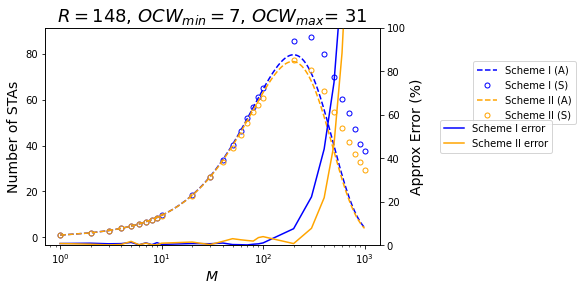

Scheme I, M = 200, Error rate = 7.498672854194902%
Scheme II, M = 300, Error rate = 7.687035866700054%


In [190]:
new_MiS_list_1, new_MiS_list_simu_1 = rotate_MiS_list(MiS_list_1, MiS_list_simu_1)
new_MiS_list_2, new_MiS_list_simu_2 = rotate_MiS_list(MiS_list_2, MiS_list_simu_2)

# ------------------------------------------------------------------------------------------------------------

display_n = 1
display_i = 1

approx_error_1 = getAna_Simu_ApproxError(new_MiS_list_1[display_i-1][display_n-1], new_MiS_list_simu_1[display_i-1][display_n-1])
approx_error_2 = getAna_Simu_ApproxError(new_MiS_list_2[display_i-1][display_n-1], new_MiS_list_simu_2[display_i-1][display_n-1])

fig, ax1 = plt.subplots()

ax1.set_xscale('log')

# ax1.plot(m_list, new_MiS_list_1[display_i-1][display_n-1], linestyle = '--', color='blue', label=f"$M_{{{display_i},S}}[{display_n}]$(A) Scheme I")
# ax1.plot(m_list_simu, new_MiS_list_simu_1[display_i-1][display_n-1], label=f"$M_{{{display_i},S}}[{display_n}]$(S) Scheme I", linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)

# ax1.plot(m_list, new_MiS_list_2[display_i-1][display_n-1], linestyle = '--', color='orange', label=f"$M_{{{display_i},S}}[{display_n}]$(A) Scheme II")
# ax1.plot(m_list_simu, new_MiS_list_simu_2[display_i-1][display_n-1], label=f"$M_{{{display_i},S}}[{display_n}]$(S) Scheme II", linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

ax1.plot(m_list, new_MiS_list_1[display_i-1][display_n-1], linestyle = '--', color='blue', label=f"Scheme I (A)")
ax1.plot(m_list_simu, new_MiS_list_simu_1[display_i-1][display_n-1], label=f"Scheme I (S)", linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)

ax1.plot(m_list, new_MiS_list_2[display_i-1][display_n-1], linestyle = '--', color='orange', label=f"Scheme II (A)")
ax1.plot(m_list_simu, new_MiS_list_simu_2[display_i-1][display_n-1], label=f"Scheme II (S)", linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

ax1.set_xlabel("$M$", fontsize = 14)
ax1.set_ylabel('Number of STAs', fontsize = 14)
ax1.legend(loc='center right', bbox_to_anchor=(1.6, 0.7), fontsize = 10)

ax2 = ax1.twinx()
ax2.plot(m_list_simu, approx_error_1, linestyle = 'solid', color='blue', label='Scheme I error')
ax2.plot(m_list_simu, approx_error_2, linestyle = 'solid', color='orange', label='Scheme II error')

ax2.set_ylabel(f'Approx Error (%)', color='black', fontsize = 14)
ax2.set_ylim([0, 100])
ax2.legend(loc='center right', bbox_to_anchor=(1.53, 0.5), fontsize = 10)


plt.title(f'$R = {R}$' + ', $OCW_{min} = $' + str(ocw_min) + ', $OCW_{max}$= ' + str(ocw_max), fontsize = 18)
plt.show()
# plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.65), fontsize = 12)

for idx, err in enumerate(approx_error_1):
    if err > 5:
        print(f'Scheme I, M = {m_list_simu[idx]}, Error rate = {err}%')
        break;
for idx, err in enumerate(approx_error_2):
    if err > 5:
        print(f'Scheme II, M = {m_list_simu[idx]}, Error rate = {err}%')
        break;

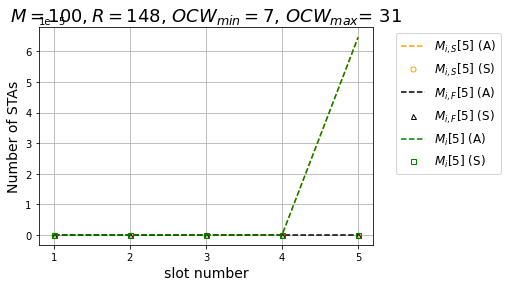

In [191]:
M_num = 100
# M_num_simu_idx = np.where(m_list_simu == M_num)[0]
M_num_simu_idx = int(M_num / 10) - 1
display_n = 5

plt.plot([str(i+1) for i in range(Imax)], MiS_list_1[M_num-1][display_n-1], linestyle = '--', color='orange', label='$M_{i,S}$'+f'[{display_n}]'+' (A)')
plt.plot([str(i+1) for i in range(Imax)], MiS_list_simu_1[M_num_simu_idx][display_n-1], label='$M_{i,S}$'+f'[{display_n}]'+' (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.plot([str(i+1) for i in range(Imax)], MiF_list_1[M_num-1][display_n-1], linestyle = '--', color='black', label='$M_{i,F}$'+f'[{display_n}]'+' (A)')
plt.plot([str(i+1) for i in range(Imax)], MiF_list_simu_1[M_num_simu_idx][display_n-1], label='$M_{i,F}$'+f'[{display_n}]'+' (S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='black', markersize=5)

plt.plot([str(i+1) for i in range(Imax)], Mi_n_list_1[M_num-1][display_n-1], linestyle = '--', color='green', label='$M_{i}$'+f'[{display_n}]'+' (A)')
plt.plot([str(i+1) for i in range(Imax)], Mi_n_list_simu_1[M_num_simu_idx][display_n-1], label='$M_{i}$'+f'[{display_n}]'+' (S)', linestyle='None', marker='s', markerfacecolor='None', markeredgecolor='green', markersize=5)


plt.title(f'$M={M_num}, R = {R}$' + ', $OCW_{min} = $' + str(ocw_min) + ', $OCW_{max}$= ' + str(ocw_max), fontsize = 18)
# plt.title(f'$M={M_num}, R = {R}$' + ', $OCW_{min} = $' + str(ocw_min) + ', $OCW_{max}$= ' + str(ocw_max) + f', scheme{scheme}', fontsize = 18)
plt.xlabel("slot number", fontsize = 14)
plt.ylabel("Number of STAs", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.65), fontsize = 12)

plt.show()

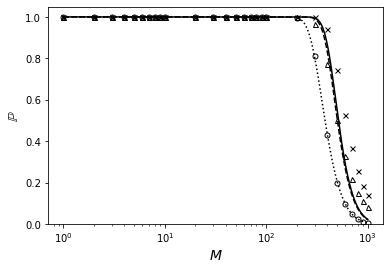

In [192]:
fig, ax1 = plt.subplots()

ax1.set_xscale('log')

# General UORA (Fixed power)
ax1.plot(m_list, ps_list, linestyle = 'dotted', color='black', label='UORA(A)')
ax1.plot(m_list_simu, Ps_list_simu, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
# random
ax1.plot(m_list, ps_list_1, linestyle = 'solid', color='black', label='Scheme I (A)')
ax1.plot(m_list_simu, Ps_list_simu_1, label='Scheme I (S)', linestyle='None', marker='x', markerfacecolor='None', markeredgecolor='black', markersize=5)
# ramping
ax1.plot(m_list, ps_list_2, linestyle = 'dashed', color='black', label='Scheme II (A)')
ax1.plot(m_list_simu, Ps_list_simu_2, label='Scheme II (S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='black', markersize=5)

# ax1.plot(m_list, ps_list, linestyle = '--', color='orange', label=f'Ana')
# ax1.plot(m_list_simu, Ps_list_simu, label=f'Sim', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

ax1.set_xlabel("$M$", fontsize = 14)
ax1.set_ylabel('$\mathbb{P}$', fontsize = 14)
# ax1.legend(loc='center right', bbox_to_anchor=(1.5, 1), fontsize = 12)
ax1.set_ylim([0, 1.05])

# ax2 = ax1.twinx()
# ax2.plot(m_list_simu, ps_approx_error, linestyle = '--', color='green', label=f'Ana')
# ax2.set_ylabel(f'Approx Error (%)', color='g', fontsize = 14)
# ax2.set_ylim([0, 100])

# plt.title(f'$R = {R}$' + ', $OCW_{min} = $' + str(ocw_min) + ', $OCW_{max}$= ' + str(ocw_max), fontsize = 18)
plt.show()

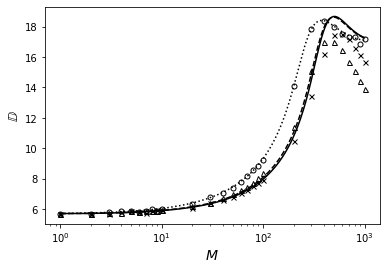

In [193]:
fig, ax1 = plt.subplots()

ax1.set_xscale('log')

# General UORA (Fixed power)
ax1.plot(m_list, da_list, linestyle = 'dotted', color='black', label='UORA(A)')
ax1.plot(m_list_simu, Da_list_simu, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
# random
ax1.plot(m_list, da_list_1, linestyle = 'solid', color='black', label='Scheme I (A)')
ax1.plot(m_list_simu, Da_list_simu_1, label='Scheme I (S)', linestyle='None', marker='x', markerfacecolor='None', markeredgecolor='black', markersize=5)
# ramping
ax1.plot(m_list, da_list_2, linestyle = 'dashed', color='black', label='Scheme II (A)')
ax1.plot(m_list_simu, Da_list_simu_2, label='Scheme II (S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='black', markersize=5)


# ax1.plot(m_list, da_list, linestyle = '--', color='orange', label=f'Ana')
# ax1.plot(m_list_simu, Da_list_simu, label=f'Sim', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

ax1.set_xlabel("$M$", fontsize = 14)
plt.ylabel("$\mathbb{D}$", fontsize = 14)

# ax2 = ax1.twinx()
# ax2.plot(m_list_simu, da_approx_error, linestyle = '--', color='green', label=f'Ana')
# ax2.set_ylabel(f'Approx Error (%)', color='g', fontsize = 14)
# ax2.set_ylim([0, 100])

# plt.title(f'$R = {R}$' + ', $OCW_{min} = $' + str(ocw_min) + ', $OCW_{max}$= ' + str(ocw_max), fontsize = 18)
plt.show()

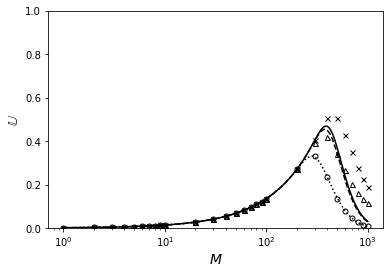

In [194]:
fig, ax1 = plt.subplots()

ax1.set_xscale('log')

# General UORA (Fixed power)
ax1.plot(m_list, u_list, linestyle = 'dotted', color='black', label='UORA(A)')
ax1.plot(m_list_simu, U_list_simu, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
# random
ax1.plot(m_list, u_list_1, linestyle = 'solid', color='black', label='Scheme I (A)')
ax1.plot(m_list_simu, U_list_simu_1, label='Scheme I (S)', linestyle='None', marker='x', markerfacecolor='None', markeredgecolor='black', markersize=5)
# ramping
ax1.plot(m_list, u_list_2, linestyle = 'dashed', color='black', label='Scheme II (A)')
ax1.plot(m_list_simu, U_list_simu_2, label='Scheme II (S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='black', markersize=5)

ax1.set_ylim([0, 1])

# ax1.plot(m_list, u_list, linestyle = '--', color='orange', label=f'Ana')
# ax1.plot(m_list_simu, U_list_simu, label=f'Sim', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)
# ax1.set_ylim([0, 1])

ax1.set_xlabel("$M$", fontsize = 14)
plt.ylabel("$\mathbb{U}$", fontsize = 14)

# ax2 = ax1.twinx()
# ax2.plot(m_list_simu, u_approx_error, linestyle = '--', color='green', label=f'Ana')
# ax2.set_ylabel(f'Approx Error (%)', color='g', fontsize = 14)
# ax2.set_ylim([0, 100])

# plt.title(f'$R = {R}$' + ', $OCW_{min} = $' + str(ocw_min) + ', $OCW_{max}$= ' + str(ocw_max), fontsize = 18)
plt.show()

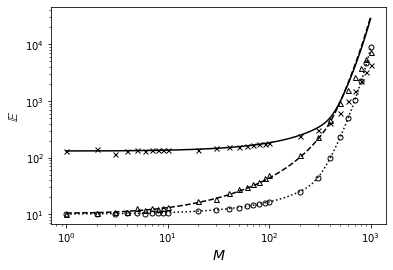

In [195]:
fig, ax1 = plt.subplots()

ax1.set_xscale('log')
ax1.set_yscale('log')

# General UORA (Fixed power)
ax1.plot(m_list, power_list, linestyle = 'dotted', color='black', label='UORA(A)')
ax1.plot(m_list_simu, power_list_simu, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
# random
ax1.plot(m_list, power_list_1, linestyle = 'solid', color='black', label='Scheme I (A)')
ax1.plot(m_list_simu, power_list_simu_1, label='Scheme I (S)', linestyle='None', marker='x', markerfacecolor='None', markeredgecolor='black', markersize=5)
# ramping
ax1.plot(m_list, power_list_2, linestyle = 'dashed', color='black', label='Scheme II (A)')
ax1.plot(m_list_simu, power_list_simu_2, label='Scheme II (S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='black', markersize=5)

# ax1.plot(m_list, power_list, linestyle = '--', color='orange', label=f'Ana')
# ax1.plot(m_list_simu, power_list_simu, label=f'Sim', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

ax1.set_xlabel("$M$", fontsize = 14)
plt.ylabel("$\mathbb{E}$", fontsize = 14)

# ax2 = ax1.twinx()
# ax2.plot(m_list_simu, power_approx_error, linestyle = '--', color='green', label=f'Ana')
# ax2.set_ylabel(f'Approx Error (%)', color='g', fontsize = 14)
# ax2.set_ylim([0, 100])

# plt.title(f'$R = {R}$' + ', $OCW_{min} = $' + str(ocw_min) + ', $OCW_{max}$= ' + str(ocw_max), fontsize = 18)
plt.show()